# Import Needed Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , label_binarize
from sklearn.decomposition import PCA
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch


[W1217 21:37:50.750343065 OperatorEntry.cpp:153] Warning: Warning only once for all operators,  other operators may also be overrided.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: torchvision::roi_align(Tensor input, Tensor rois, float spatial_scale, SymInt pooled_height, SymInt pooled_width, int sampling_ratio, bool aligned) -> Tensor
    registered at /builddir/build/BUILD/python-torchvision-0.19.0-build/vision-0.19.0/torchvision/csrc/ops/roi_align.cpp:124
  dispatch key: CPU
  previous kernel: registered at /builddir/build/BUILD/python-torchvision-0.19.0-build/vision-0.19.0/torchvision/csrc/ops/quantized/cpu/qroi_align_kernel.cpp:283
       new kernel: registered at /builddir/build/BUILD/python-torchvision-0.19.0-build/vision-0.19.0/torchvision/csrc/ops/cpu/roi_align_kernel.cpp:390 (function operator())


# Load Data

In [2]:
# Point to the extracted directory
data_root = './data/'

train_data = datasets.STL10(root=data_root, split='train')
test_data = datasets.STL10(root=data_root, split='test')

In [3]:
img , label = train_data[0]
train_data.classes[label]

'bird'

In [4]:
train_data

Dataset STL10
    Number of datapoints: 5000
    Root location: ./data/
    Split: train

**Visualize samples of data**

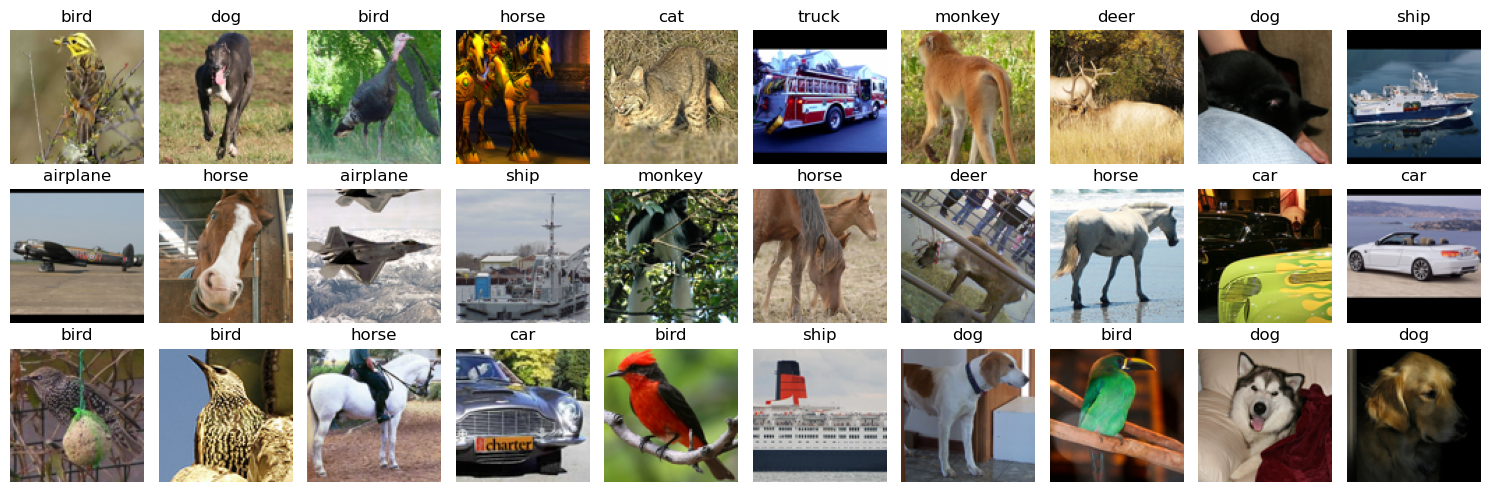

In [6]:
transform = transforms.ToTensor()
num_of_rows = 3
classes_count = len(train_data.classes)

fig, axes = plt.subplots(num_of_rows, classes_count, figsize=(15, 5))

for row in range(3):
    for i in range(classes_count):
        img, label = train_data[i + row*classes_count]
        tensor_img = transform(img)

        tensor_img = torch.clamp(tensor_img, 0, 1)

        # Convert to numpy for display
        #                                          0      1      2
        # tensor_img in this shape            (Channels,Height,Width)
        #                                          1      2      0
        # permute change the order of them to (Height,Width,Channels)
        # and this is the order to display in imshow
        img_to_show = tensor_img.permute(1, 2, 0).numpy()
    

        axes[row, i].imshow(img_to_show) # imshow takes numpy 
        axes[row, i].axis('off')  # Hide axes
        axes[row, i].set_title(f"{train_data.classes[label]}")

plt.tight_layout()
plt.show()


# Processes On Data

In [7]:
def data_to_numpy(dataset):
    data = []
    labels = []
    for img, label in dataset:
        data.append(np.array(img).flatten())  
        labels.append(label)
    return np.array(data), np.array(labels)

X_train, y_train = data_to_numpy(train_data)
X_test, y_test = data_to_numpy(test_data)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Fit Models

In [10]:
knn = KNeighborsClassifier(n_neighbors=6) # 6 by test
knn.fit(X_train_pca, y_train)

y_pred_knn = knn.predict(X_test_pca)

# Accuracy

In [11]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.2f}")

KNN Accuracy: 0.34


# Loss Curve

In [33]:
knn_losses = []
# knn_acc = []
k_arr = range(1, 20)
for k in k_arr:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_pca, y_train)
    train_acc = accuracy_score(y_train, knn_temp.predict(X_train_pca))
    knn_losses.append(1 - train_acc)


print(f"KNN Best Loss: {min(knn_losses):.2f}")

KNN Best Loss: 0.00


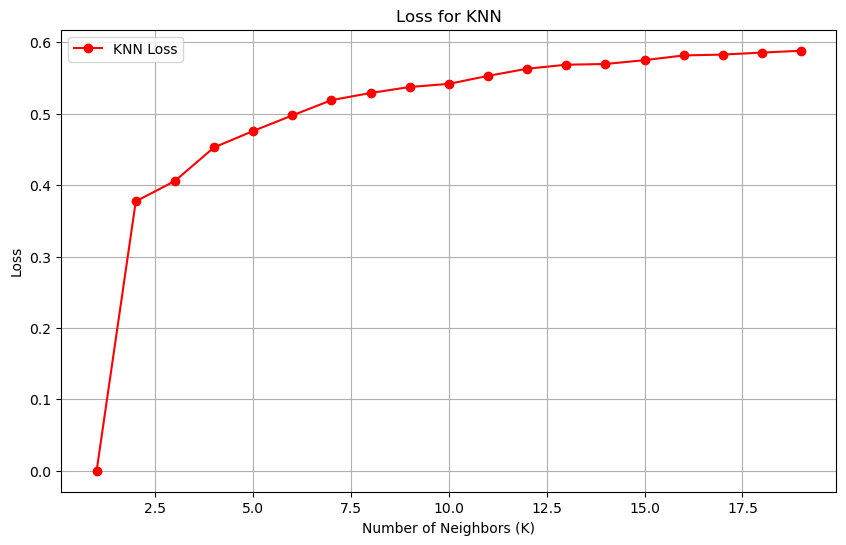

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(k_arr, knn_losses, label="KNN Loss", color="red", marker="o")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Loss")
plt.title("Loss for KNN")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix

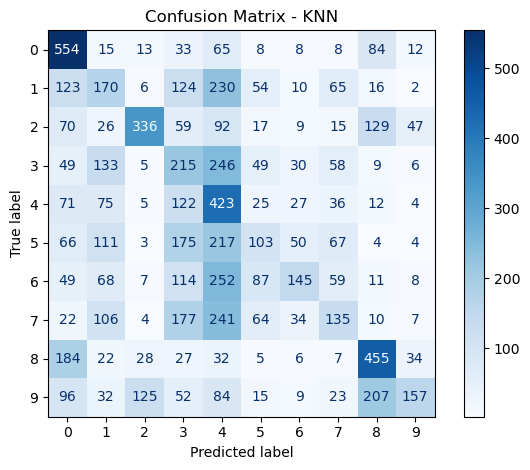

In [34]:
cm_knn = confusion_matrix(y_test, y_pred_knn)


disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=np.unique(y_test))
disp_knn.plot( cmap='Blues', values_format='d')

plt.title('Confusion Matrix - KNN')
plt.tight_layout()
plt.show()

# ROC Curve

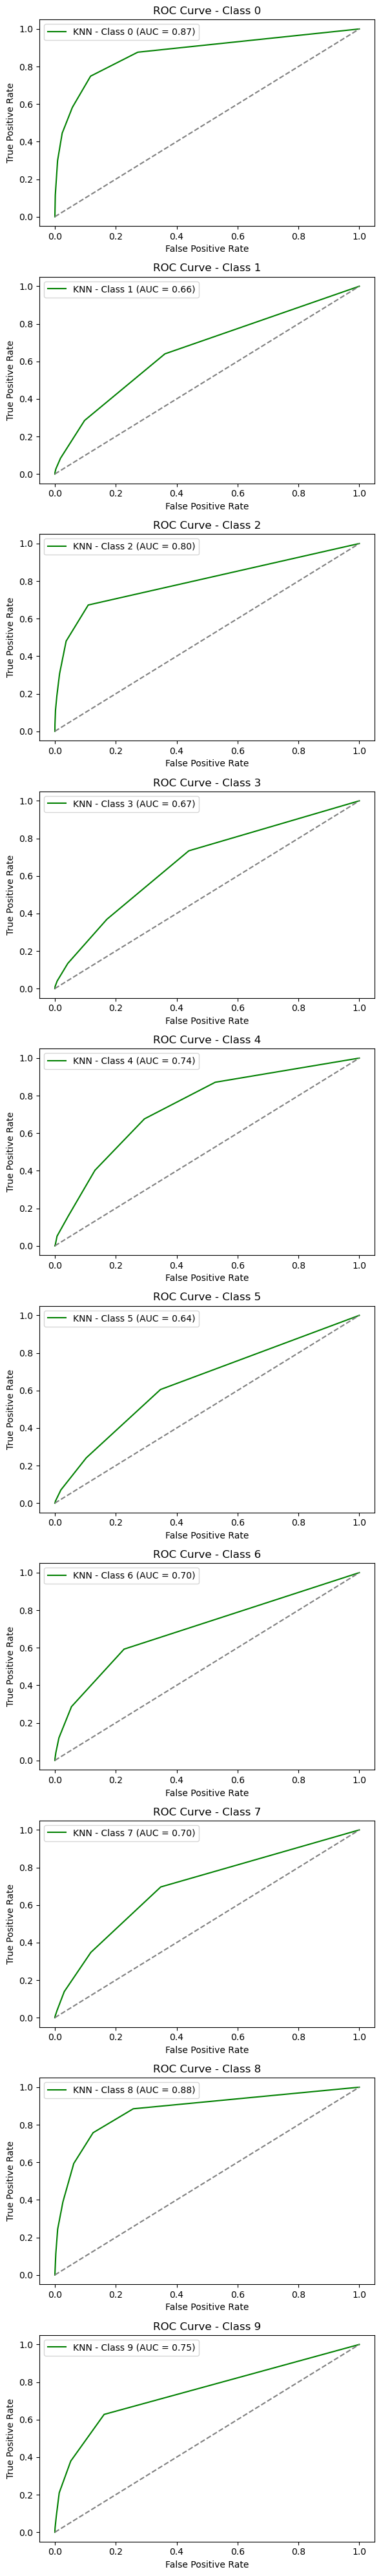

In [47]:
fig, axes = plt.subplots(num_classes, 1, figsize=(6, 4 * num_classes))

for i in range(num_classes):
    axes[i].plot(fpr_knn[i], tpr_knn[i], color='green', label=f'KNN - Class {i} (AUC = {auc(fpr_knn[i], tpr_knn[i]):.2f})')
    axes[i].plot([0, 1], [0, 1], color='gray', linestyle='--')  
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve - Class {i}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [53]:
auc_log_reg = {}
auc_knn = {}

for i in range(y_train_bin.shape[1]):
    auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])  

avg_auc_knn = np.mean(list(auc_knn.values()))

print(f"Average AUC for KNN: {avg_auc_knn:.2f}")

Average AUC for KNN: 0.74
